<a href="https://colab.research.google.com/github/Raghad-Odwan/DermAI-Train/blob/main/DermAI_Model_Training_Final_V2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Raghad.M**



---



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p /content/drive/MyDrive/checkpoints

In [5]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
%%javascript
function ClickConnect(){
    console.log("Preventing Colab timeout");
    document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 60000)

<IPython.core.display.Javascript object>



---



# **DermAI_AI_Model_Training**

This Google Colab notebook has been prepared for the preparation and training of a machine learning model specialized in skin cancer detection.
The model performs binary classification of skin lesion images into two categories: Benign and Malignant.


### Dataset Source

The dataset used in this project was collected from the following sources:
(                  _____                )

The dataset contains approximately 13,249 benign and 6,211 malignant images, providing a total of around 19,460 samples used for training, validation, and testing.




---




### Notebook Structure

This notebook is organized into three main sections:

**-Data Loading, Verification, and Preprocessing**

This section focuses on importing the dataset, verifying its structure, cleaning inconsistencies, and performing Exploratory Data Analysis (EDA).
Steps include resizing, normalization, data augmentation, and splitting the dataset into training, validation, and testing subsets.

**-Model Training and Evaluation**

In this section, a machine learning model is implemented and trained for skin lesion classification.
The process includes model configuration, training, and performance evaluation using metrics such as accuracy, precision, recall, and F1-score.
Optimization methods are also applied to ensure stable and efficient training.

**-Result Interpretation and Visualization**

This part is dedicated to analyzing the model’s predictions and interpreting its decision-making process using Grad-CAM and other visualization tools.
It highlights how the model distinguishes between benign and malignant lesions, providing insights into reliability and interpretability.



---


**Note: This notebook represents a core component of the DermAI Graduation Project at Palestine Technical University – Kadoorie.
It aims to demonstrate the end-to-end process of building an intelligent, interpretable, and efficient system for skin cancer classification, contributing to early detection and supporting clinical decision-making.**


---



## 1. **Part One: Dataset Preparation & Preprocessing**

In [7]:
# Import required libraries
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Define main dataset path
base_dir = "/content/drive/MyDrive/Dataset/Dataset"
folders = ["benign", "malignant"]

print("Base directory:", base_dir)
for folder in folders:
    path = os.path.join(base_dir, folder)
    print(f"{folder}: {len(os.listdir(path))} files")

Base directory: /content/drive/MyDrive/Dataset/Dataset
benign: 13294 files
malignant: 6211 files


In [9]:
# Create a folder for problematic images
dup_dir = os.path.join(base_dir, "duplicates_or_corrupted")
os.makedirs(dup_dir, exist_ok=True)
print("Duplicate/Corrupted folder created at:", dup_dir)

Duplicate/Corrupted folder created at: /content/drive/MyDrive/Dataset/Dataset/duplicates_or_corrupted


In [10]:
# Define an image cleaning class
class ImageCleaner:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.folders_to_check = ['benign', 'malignant']
        self.problem_folder = self.base_path / 'duplicates_or_corrupted'
        self.problem_folder.mkdir(exist_ok=True)
        self.stats = {'total_checked': 0, 'corrupted': 0, 'duplicates': 0, 'low_quality': 0, 'healthy': 0}
        self.image_hashes = defaultdict(list)

    def calculate_hash(self, image_path):
        import hashlib
        try:
            hasher = hashlib.md5()
            with open(image_path, 'rb') as f:
                buf = f.read()
                hasher.update(buf)
            return hasher.hexdigest()
        except:
            return None

    def is_image_corrupted(self, image_path):
        try:
            with Image.open(image_path) as img:
                img.verify()
            return False
        except:
            return True

    def check_image_quality(self, image_path, min_width=50, min_height=50):
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                if width < min_width or height < min_height:
                    return False
                if os.path.getsize(image_path) < 1000:
                    return False
            return True
        except:
            return False

    def move_to_problem_folder(self, image_path):
        try:
            dest_subfolder = self.problem_folder / image_path.parent.name
            dest_subfolder.mkdir(exist_ok=True)
            shutil.move(str(image_path), str(dest_subfolder / image_path.name))
        except Exception as e:
            print(f"Error moving {image_path.name}: {e}")

    def clean_folder(self, folder_name):
        folder_path = self.base_path / folder_name
        image_exts = ['.jpg', '.jpeg', '.png']
        images = [f for f in folder_path.iterdir() if f.suffix.lower() in image_exts]
        print(f"Cleaning {folder_name} ({len(images)} images)...")

        for img_path in tqdm(images, desc=f"Checking {folder_name}"):
            self.stats['total_checked'] += 1
            if self.is_image_corrupted(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['corrupted'] += 1
                continue
            if not self.check_image_quality(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['low_quality'] += 1
                continue
            img_hash = self.calculate_hash(img_path)
            if img_hash in self.image_hashes:
                self.move_to_problem_folder(img_path)
                self.stats['duplicates'] += 1
            else:
                self.image_hashes[img_hash].append(str(img_path))
                self.stats['healthy'] += 1

    def clean_all(self):
        for folder in self.folders_to_check:
            self.clean_folder(folder)
        print("\nCleaning Summary:")
        for k, v in self.stats.items():
            print(f"{k}: {v}")

# Run the cleaning process
cleaner = ImageCleaner(base_dir)
cleaner.clean_all()

Cleaning benign (13294 images)...


Checking benign: 100%|██████████| 13294/13294 [06:36<00:00, 33.56it/s] 


Cleaning malignant (6211 images)...


Checking malignant: 100%|██████████| 6211/6211 [02:38<00:00, 39.28it/s] 


Cleaning Summary:
total_checked: 19505
corrupted: 0
duplicates: 0
low_quality: 0
healthy: 19505


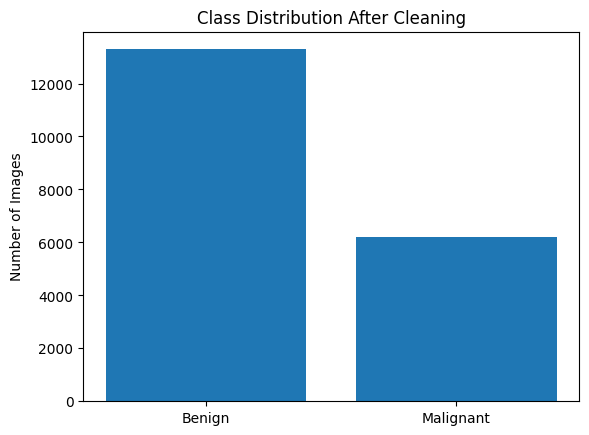

In [11]:
# Visualize class distribution
count_benign = len(os.listdir(os.path.join(base_dir, "benign")))
count_malignant = len(os.listdir(os.path.join(base_dir, "malignant")))
plt.bar(["Benign", "Malignant"], [count_benign, count_malignant])
plt.title("Class Distribution After Cleaning")
plt.ylabel("Number of Images")
plt.show()

In [12]:
# Resize all images to (224x224)
IMG_SIZE = (224, 224)
for cat in folders:
    src_dir = os.path.join(base_dir, cat)
    files = os.listdir(src_dir)
    for fname in tqdm(files, desc=f"Resizing {cat}"):
        path = os.path.join(src_dir, fname)
        try:
            img = cv2.imread(path)
            if img is None: continue
            resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(path, resized)
        except:
            continue

Resizing malignant: 100%|██████████| 6211/6211 [01:58<00:00, 52.36it/s]


In [13]:
# Split dataset (70% train, 15% val, 15% test)
split_dir = "/content/ai/Dataset_split"
os.makedirs(split_dir, exist_ok=True)

rows = []
for label in folders:
    path = os.path.join(base_dir, label)
    for fname in os.listdir(path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            rows.append({'path': os.path.join(path, fname), 'label': label})

df = pd.DataFrame(rows)
train_temp, test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train, val = train_test_split(train_temp, test_size=0.1765, stratify=train_temp['label'], random_state=42)

for subset in ['train', 'val', 'test']:
    for label in folders:
        os.makedirs(os.path.join(split_dir, subset, label), exist_ok=True)

def copy_images(df_subset, subset_name):
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc=f"Copying {subset_name}"):
        dest = os.path.join(split_dir, subset_name, row['label'], os.path.basename(row['path']))
        shutil.copy2(row['path'], dest)

copy_images(train, "train")
copy_images(val, "val")
copy_images(test, "test")

print(f"\nDataset split completed successfully!")
print(f"Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")

Copying test: 100%|██████████| 2926/2926 [00:10<00:00, 269.45it/s]


Dataset split completed successfully!
Train: 13652 | Val: 2927 | Test: 2926




---

####  Build DataFrame & Quick Integrity Check

In [14]:
# Count the number of image files in each class folder (benign and malignant)
# This function walks through all subdirectories and counts only valid image files.
import os, sys, traceback
base_path = "/content/drive/MyDrive/Dataset/Dataset"

def count_images_in_folder(folder):
    exts = ('.jpg','.jpeg','.png','.bmp')
    cnt = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(exts):
                cnt += 1
    return cnt

for cls in ['benign','malignant']:
    p = os.path.join(base_path, cls)
    if not os.path.exists(p):
        print(f" WARNING: folder not found: {p}")
    else:
        print(f"{cls}: {count_images_in_folder(p):,} images")

benign: 13,294 images
malignant: 6,211 images


In [15]:
import os
import pandas as pd
from PIL import Image
import random
# build dataframe (paths + labels)
rows=[]
exts = ('.jpg','.jpeg','.png','.bmp')
for cls in ['benign','malignant']:
    folder = os.path.join(base_path, cls)
    if not os.path.exists(folder):
        continue
    for root, dirs, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(exts):
                rows.append({'path': os.path.join(root, fname), 'label': cls})

df = pd.DataFrame(rows)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['label_idx'] = df['label'].map({'benign':0, 'malignant':1})
print("Total samples:", len(df))
print(df['label'].value_counts())

Total samples: 19505
label
benign       13294
malignant     6211
Name: count, dtype: int64


In [16]:
#  quick corrupted-files check (lightweight, may take time if dataset big)
#  try to open the first N images from each class to detect obvious corruption
from PIL import Image
import random

def check_samples(df, n_per_class=20):
    corrupted = []
    for cls in df['label'].unique():
        paths = df[df['label']==cls]['path'].tolist()
        sample_paths = random.sample(paths, min(n_per_class, len(paths)))
        for p in sample_paths:
            try:
                img = Image.open(p)
                img.verify()
            except Exception as e:
                corrupted.append((p, str(e)))
    return corrupted

corrupted_examples = check_samples(df, n_per_class=30)
if corrupted_examples:
    print(" Found corrupted or unreadable sample(s):", len(corrupted_examples))
    for p,err in corrupted_examples[:5]:
        print("-", p, "=>", err)
else:
    print(" Quick corrupted-sample check passed successfully (no issues in sampled files).")

 Quick corrupted-sample check passed successfully (no issues in sampled files).


In [17]:
# Save metadata CSV
out_csv = "/content/drive/MyDrive/ai/data/df_metadata.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df.to_csv(out_csv, index=False)
print(" Metadata saved to:", out_csv)

 Metadata saved to: /content/drive/MyDrive/ai/data/df_metadata.csv


In [18]:
display(df.head(10))
print("\nCounts (sanity):")
print(df['label'].value_counts())

,path,label,label_idx
0,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
1,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
2,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
3,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
4,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
5,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
6,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
7,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
8,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
9,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1



Counts (sanity):
label
benign       13294
malignant     6211
Name: count, dtype: int64


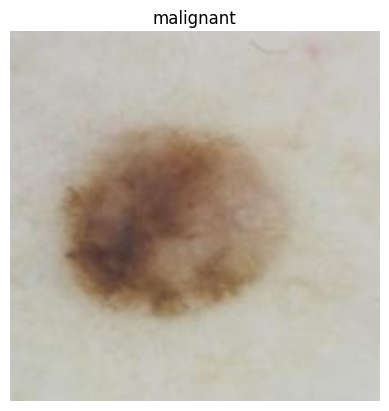

In [19]:
# Quick test reading data
# Randomly load and display one sample image from the dataset
# to verify that image paths are correct and preprocessing worked properly.
from tensorflow.keras.preprocessing import image
import numpy as np
import random
import matplotlib.pyplot as plt

sample = random.choice(df['path'].tolist())
img = image.load_img(sample, target_size=(224,224))
plt.imshow(img)
plt.axis('off')
plt.title(sample.split('/')[-2])
plt.show()



---



## **Part Two: Model Training and Evaluation**

In [20]:
# Import libraries
import os, math, gc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger

# Parameters
# Defines image size, batch size, epochs, and model saving directory
DRIVE_BASE = "/content/drive/MyDrive"
DF_PATH = os.path.join(DRIVE_BASE, "ai/data/df_metadata.csv")
MODELS_DIR = os.path.join(DRIVE_BASE, "DermAI_models_resnet")
os.makedirs(MODELS_DIR, exist_ok=True)

IMG_SIZE = (224,224)
BATCH_SIZE = 16
EPOCHS = 15
N_FOLDS = 3
RANDOM_STATE = 42
VERBOSE = 1

In [21]:
# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [22]:
# Read & Inspect Metadata
meta_csv = "/content/drive/MyDrive/ai/data/df_metadata.csv"
df = pd.read_csv(meta_csv)

print("Loaded df:", meta_csv)
print("Total samples:", len(df))
print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nFirst 10 rows:")
display(df.head(10))

# Prepare X and y for training
X = df['path'].values
y = df['label_idx'].values

Loaded df: /content/drive/MyDrive/ai/data/df_metadata.csv
Total samples: 19505

Label distribution:
label
benign       13294
malignant     6211
Name: count, dtype: int64

First 10 rows:


,path,label,label_idx
0,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
1,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
2,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
3,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
4,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
5,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
6,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
7,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
8,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
9,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1


Data Generators

Prepare image generators for training and validation.
Training generator applies data augmentation to improve model generalization, while validation generator only rescales pixel values.
Tralies moderate augmentation; validation only rescales.ining generator app

In [23]:
# Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)



---





---



Model Building

In [24]:
#  Build ResNet binary head (fine-tune last N layers)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import mixed_precision

# ensure mixed precision final output safe (if used)
# mixed_precision.set_global_policy('mixed_float16')  # already set earlier if used

def build_resnet_binary(input_shape=(224,224,3), unfreeze_last_n=40):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # freeze all
    for layer in base.layers:
        layer.trainable = False
    # unfreeze last N layers except BatchNorm for stability
    for layer in base.layers[-unfreeze_last_n:]:
        if 'batch_normalization' in layer.name:
            layer.trainable = False
        else:
            layer.trainable = True

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid', dtype='float32')(x)  # float32 output
    model = Model(inputs=base.input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model



---





---



In [25]:
# Utility Functions for Dataset Loading & Preprocessing
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def compute_weights(y_array):
    classes = np.unique(y_array)
    cw = compute_class_weight('balanced', classes=classes, y=y_array)
    return {int(c): float(w) for c,w in zip(classes, cw)}

def print_generator_info(gen, name="generator"):
    print(f"{name} class_indices:", getattr(gen, 'class_indices', None))
    if hasattr(gen, 'classes'):
        u,c = np.unique(gen.classes, return_counts=True)
        print(f"{name} counts:", dict(zip(u,c)))



---





---



For each fold:
• Split data into training and validation subsets while preserving class balance.
• Build and train a ResNet50 model on the training subset.
• Evaluate model performance on the validation subset (Accuracy, Precision, Recall, F1).
• Save best model weights and record per-fold metrics.
And after that Results from all folds are stored in 'fold_metrics' for later summary and analysis.

In [32]:
import math, gc, os
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

df = pd.read_csv('/content/drive/MyDrive/ai/data/df_metadata.csv')
df_cv = df.copy()

x = df_cv['path'].values
y = df_cv['label_idx'].values

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
splits = list(skf.split(X, y))

##### Fold 1

In [33]:
# Fold 1
# Model Training
fold_no = 1
train_idx, val_idx = splits[0]
train_df = pd.DataFrame({'path': X[train_idx], 'label_idx': y[train_idx]})
val_df   = pd.DataFrame({'path': X[val_idx],   'label_idx': y[val_idx]})

class_weight = compute_weights(train_df['label_idx'].values)
print("class_weight:", class_weight)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label_idx',
                                              target_size=IMG_SIZE, class_mode='raw',
                                              batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label_idx',
                                          target_size=IMG_SIZE, class_mode='raw',
                                          batch_size=BATCH_SIZE, shuffle=False)

print_generator_info(train_gen, "train_gen")
print_generator_info(val_gen, "val_gen")

model = build_resnet_binary(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), unfreeze_last_n=40)

ckpt_path = os.path.join(MODELS_DIR, f"best_resnet_fold{fold_no}.keras")
csv_log_path = os.path.join(MODELS_DIR, f"training_log_fold{fold_no}.csv")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    CSVLogger(csv_log_path)
]

steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
val_steps = math.ceil(len(val_df) / BATCH_SIZE)

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=VERBOSE
)

best = tf.keras.models.load_model(ckpt_path)
val_gen_eval = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label_idx',
                                               target_size=IMG_SIZE, class_mode='raw',
                                               batch_size=BATCH_SIZE, shuffle=False)
preds_prob = best.predict(val_gen_eval, steps=val_steps, verbose=VERBOSE)
preds = (preds_prob.ravel() > 0.5).astype(int)
true = val_df['label_idx'].values[:len(preds)]

acc = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec = recall_score(true, preds, zero_division=0)
f1 = f1_score(true, preds, zero_division=0)

print(f"Fold {fold_no} -> acc:{acc:.4f}, prec:{prec:.4f}, rec:{rec:.4f}, f1:{f1:.4f}")
print(classification_report(true, preds, target_names=['benign','malignant'], zero_division=0))
print("Confusion matrix:\n", confusion_matrix(true, preds))

tf.keras.backend.clear_session()
gc.collect()

class_weight: {0: 0.7336380049650192, 1: 1.5700313933832408}
Found 13003 validated image filenames.
Found 6502 validated image filenames.
train_gen class_indices: None
val_gen class_indices: None
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/15
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7397 - loss: 0.5301
Epoch 1: val_loss improved from inf to 1.07790, saving model to /content/drive/MyDrive/DermAI_models_resnet/best_resnet_fold1.keras
813/813 ━━━━━━━━━━━━━━━━━━━━ 292s 327ms/step - accuracy: 0.7397 - loss: 0.5301 - val_accuracy: 0.7115 - val_loss: 1.0779 - learning_rate: 1.0000e-05
Epoch 2/15
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7795 - loss: 0.4438
Epoch 2: val_loss improved from 1.07790 to 0.73127, saving model to /content/drive/MyDrive/DermAI_models_resnet/best_resnet_fold1.keras
813/813 ━━━━━━━━━━━━━━━━━━━━ 246s 302ms/step - accuracy: 0.7795 - loss: 0.4438 - val_accuracy: 0.7627 - val_loss: 0.7313 - learning_rate: 1.0000e-05
Epoch 3/15


0

Accuracy:  0.8373
Precision: 0.8338
Recall:    0.6106
F1-Score:  0.7050


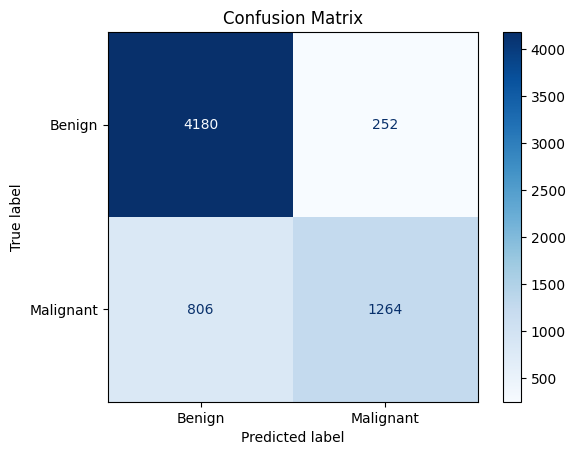

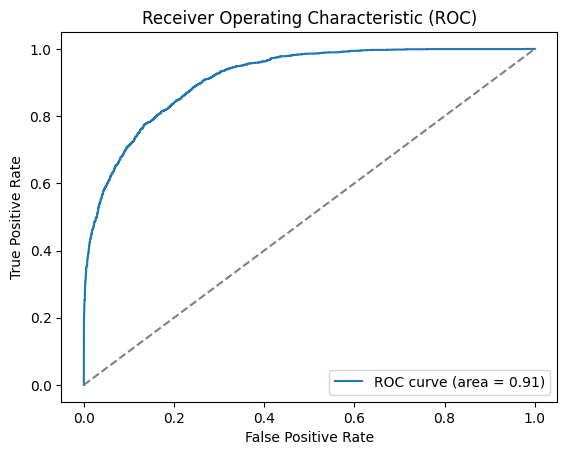

<Figure size 640x480 with 0 Axes>

In [34]:
# Evaluation Summary
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(true, preds_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Save evaluation plots
plt.savefig("evaluation_results.png", dpi=300)


##### Fold 2

In [ ]:
# Fold 2
fold_no = 2
train_idx, val_idx = splits[1]
train_df = pd.DataFrame({'path': X[train_idx], 'label_idx': y[train_idx]})
val_df   = pd.DataFrame({'path': X[val_idx],   'label_idx': y[val_idx]})

class_weight = compute_weights(train_df['label_idx'].values)
print("class_weight:", class_weight)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label_idx',
                                              target_size=IMG_SIZE, class_mode='raw',
                                              batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label_idx',
                                          target_size=IMG_SIZE, class_mode='raw',
                                          batch_size=BATCH_SIZE, shuffle=False)

print_generator_info(train_gen, "train_gen")
print_generator_info(val_gen, "val_gen")

model = build_resnet_binary(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), unfreeze_last_n=40)

ckpt_path = os.path.join(MODELS_DIR, f"best_resnet_fold{fold_no}.keras")
csv_log_path = os.path.join(MODELS_DIR, f"training_log_fold{fold_no}.csv")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    CSVLogger(csv_log_path)
]

steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
val_steps = math.ceil(len(val_df) / BATCH_SIZE)

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=VERBOSE
)

best = tf.keras.models.load_model(ckpt_path)
val_gen_eval = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label_idx',
                                               target_size=IMG_SIZE, class_mode='raw',
                                               batch_size=BATCH_SIZE, shuffle=False)
preds_prob = best.predict(val_gen_eval, steps=val_steps, verbose=VERBOSE)
preds = (preds_prob.ravel() > 0.5).astype(int)
true = val_df['label_idx'].values[:len(preds)]

acc = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec = recall_score(true, preds, zero_division=0)
f1 = f1_score(true, preds, zero_division=0)

print(f"Fold {fold_no} -> acc:{acc:.4f}, prec:{prec:.4f}, rec:{rec:.4f}, f1:{f1:.4f}")
print(classification_report(true, preds, target_names=['benign','malignant'], zero_division=0))
print("Confusion matrix:\n", confusion_matrix(true, preds))

tf.keras.backend.clear_session()
gc.collect()

class_weight: {0: 0.7335552296062281, 1: 1.5704106280193237}
Found 13003 validated image filenames.
Found 6502 validated image filenames.
train_gen class_indices: None
val_gen class_indices: None
Epoch 1/15
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7355 - loss: 0.5287
Epoch 1: val_loss improved from inf to 0.47158, saving model to /content/drive/MyDrive/DermAI_models_resnet/best_resnet_fold2.keras
813/813 ━━━━━━━━━━━━━━━━━━━━ 272s 311ms/step - accuracy: 0.7355 - loss: 0.5286 - val_accuracy: 0.7887 - val_loss: 0.4716 - learning_rate: 1.0000e-05
Epoch 2/15
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7802 - loss: 0.4389
Epoch 2: val_loss improved from 0.47158 to 0.46051, saving model to /content/drive/MyDrive/DermAI_models_resnet/best_resnet_fold2.keras
813/813 ━━━━━━━━━━━━━━━━━━━━ 238s 292ms/step - accuracy: 0.7802 - loss: 0.4389 - val_accuracy: 0.8014 - val_loss: 0.4605 - learning_rate: 1.0000e-05
Epoch 3/15
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accura

In [ ]:
# Evaluation Summary
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(true, preds_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Save evaluation plots
plt.savefig("evaluation_results.png", dpi=300)

##### Fold 3

In [ ]:
# Fold 3
fold_no = 3
train_idx, val_idx = splits[2]
train_df = pd.DataFrame({'path': X[train_idx], 'label_idx': y[train_idx]})
val_df   = pd.DataFrame({'path': X[val_idx],   'label_idx': y[val_idx]})

class_weight = compute_weights(train_df['label_idx'].values)
print("class_weight:", class_weight)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label_idx',
                                              target_size=IMG_SIZE, class_mode='raw',
                                              batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label_idx',
                                          target_size=IMG_SIZE, class_mode='raw',
                                          batch_size=BATCH_SIZE, shuffle=False)

print_generator_info(train_gen, "train_gen")
print_generator_info(val_gen, "val_gen")

model = build_resnet_binary(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), unfreeze_last_n=40)

ckpt_path = os.path.join(MODELS_DIR, f"best_resnet_fold{fold_no}.keras")
csv_log_path = os.path.join(MODELS_DIR, f"training_log_fold{fold_no}.csv")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    CSVLogger(csv_log_path)
]

steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
val_steps = math.ceil(len(val_df) / BATCH_SIZE)

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=VERBOSE
)

best = tf.keras.models.load_model(ckpt_path)
val_gen_eval = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label_idx',
                                               target_size=IMG_SIZE, class_mode='raw',
                                               batch_size=BATCH_SIZE, shuffle=False)
preds_prob = best.predict(val_gen_eval, steps=val_steps, verbose=VERBOSE)
preds = (preds_prob.ravel() > 0.5).astype(int)
true = val_df['label_idx'].values[:len(preds)]

acc = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec = recall_score(true, preds, zero_division=0)
f1 = f1_score(true, preds, zero_division=0)

print(f"Fold {fold_no} -> acc:{acc:.4f}, prec:{prec:.4f}, rec:{rec:.4f}, f1:{f1:.4f}")
print(classification_report(true, preds, target_names=['benign','malignant'], zero_division=0))
print("Confusion matrix:\n", confusion_matrix(true, preds))

tf.keras.backend.clear_session()
gc.collect()

In [ ]:
# Evaluation Summary
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(true, preds_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Save evaluation plots
plt.savefig("evaluation_results.png", dpi=300)



---



---



In [ ]:
#Grad-CAM Visualization



---





---



### Part Three